# **iCNN**

This notebook is based on the first programming exercise of the CNN course of DeepLearningAI on Coursera and contains basic functions for forward and backward propagation in a Convolutional Neural Network.

A vectorized implementation of forward and backward propagation is formulated, which is about 100x faster than the one implemented in Coursera (which uses for-loops).

In [ ]:
# Useful Packages
import numpy as np

# Some useful functions (before I found out np.floor and np.ceil :-P)
def RoundUpDiv (numerator, denominator):
    
    """
    This function rounds up the quotient to the nearest high integer.
    
    """
    div = int(numerator/denominator) + (numerator%denominator > 0)
    return div

def RoundUp (x):
    
    """
    This function rounds up to the nearest integer.
    
    """
    roundUp = int(x) + (x - int(x) > 0)
    return roundUp

# **Forward Propagation**
# **Conv2D:**

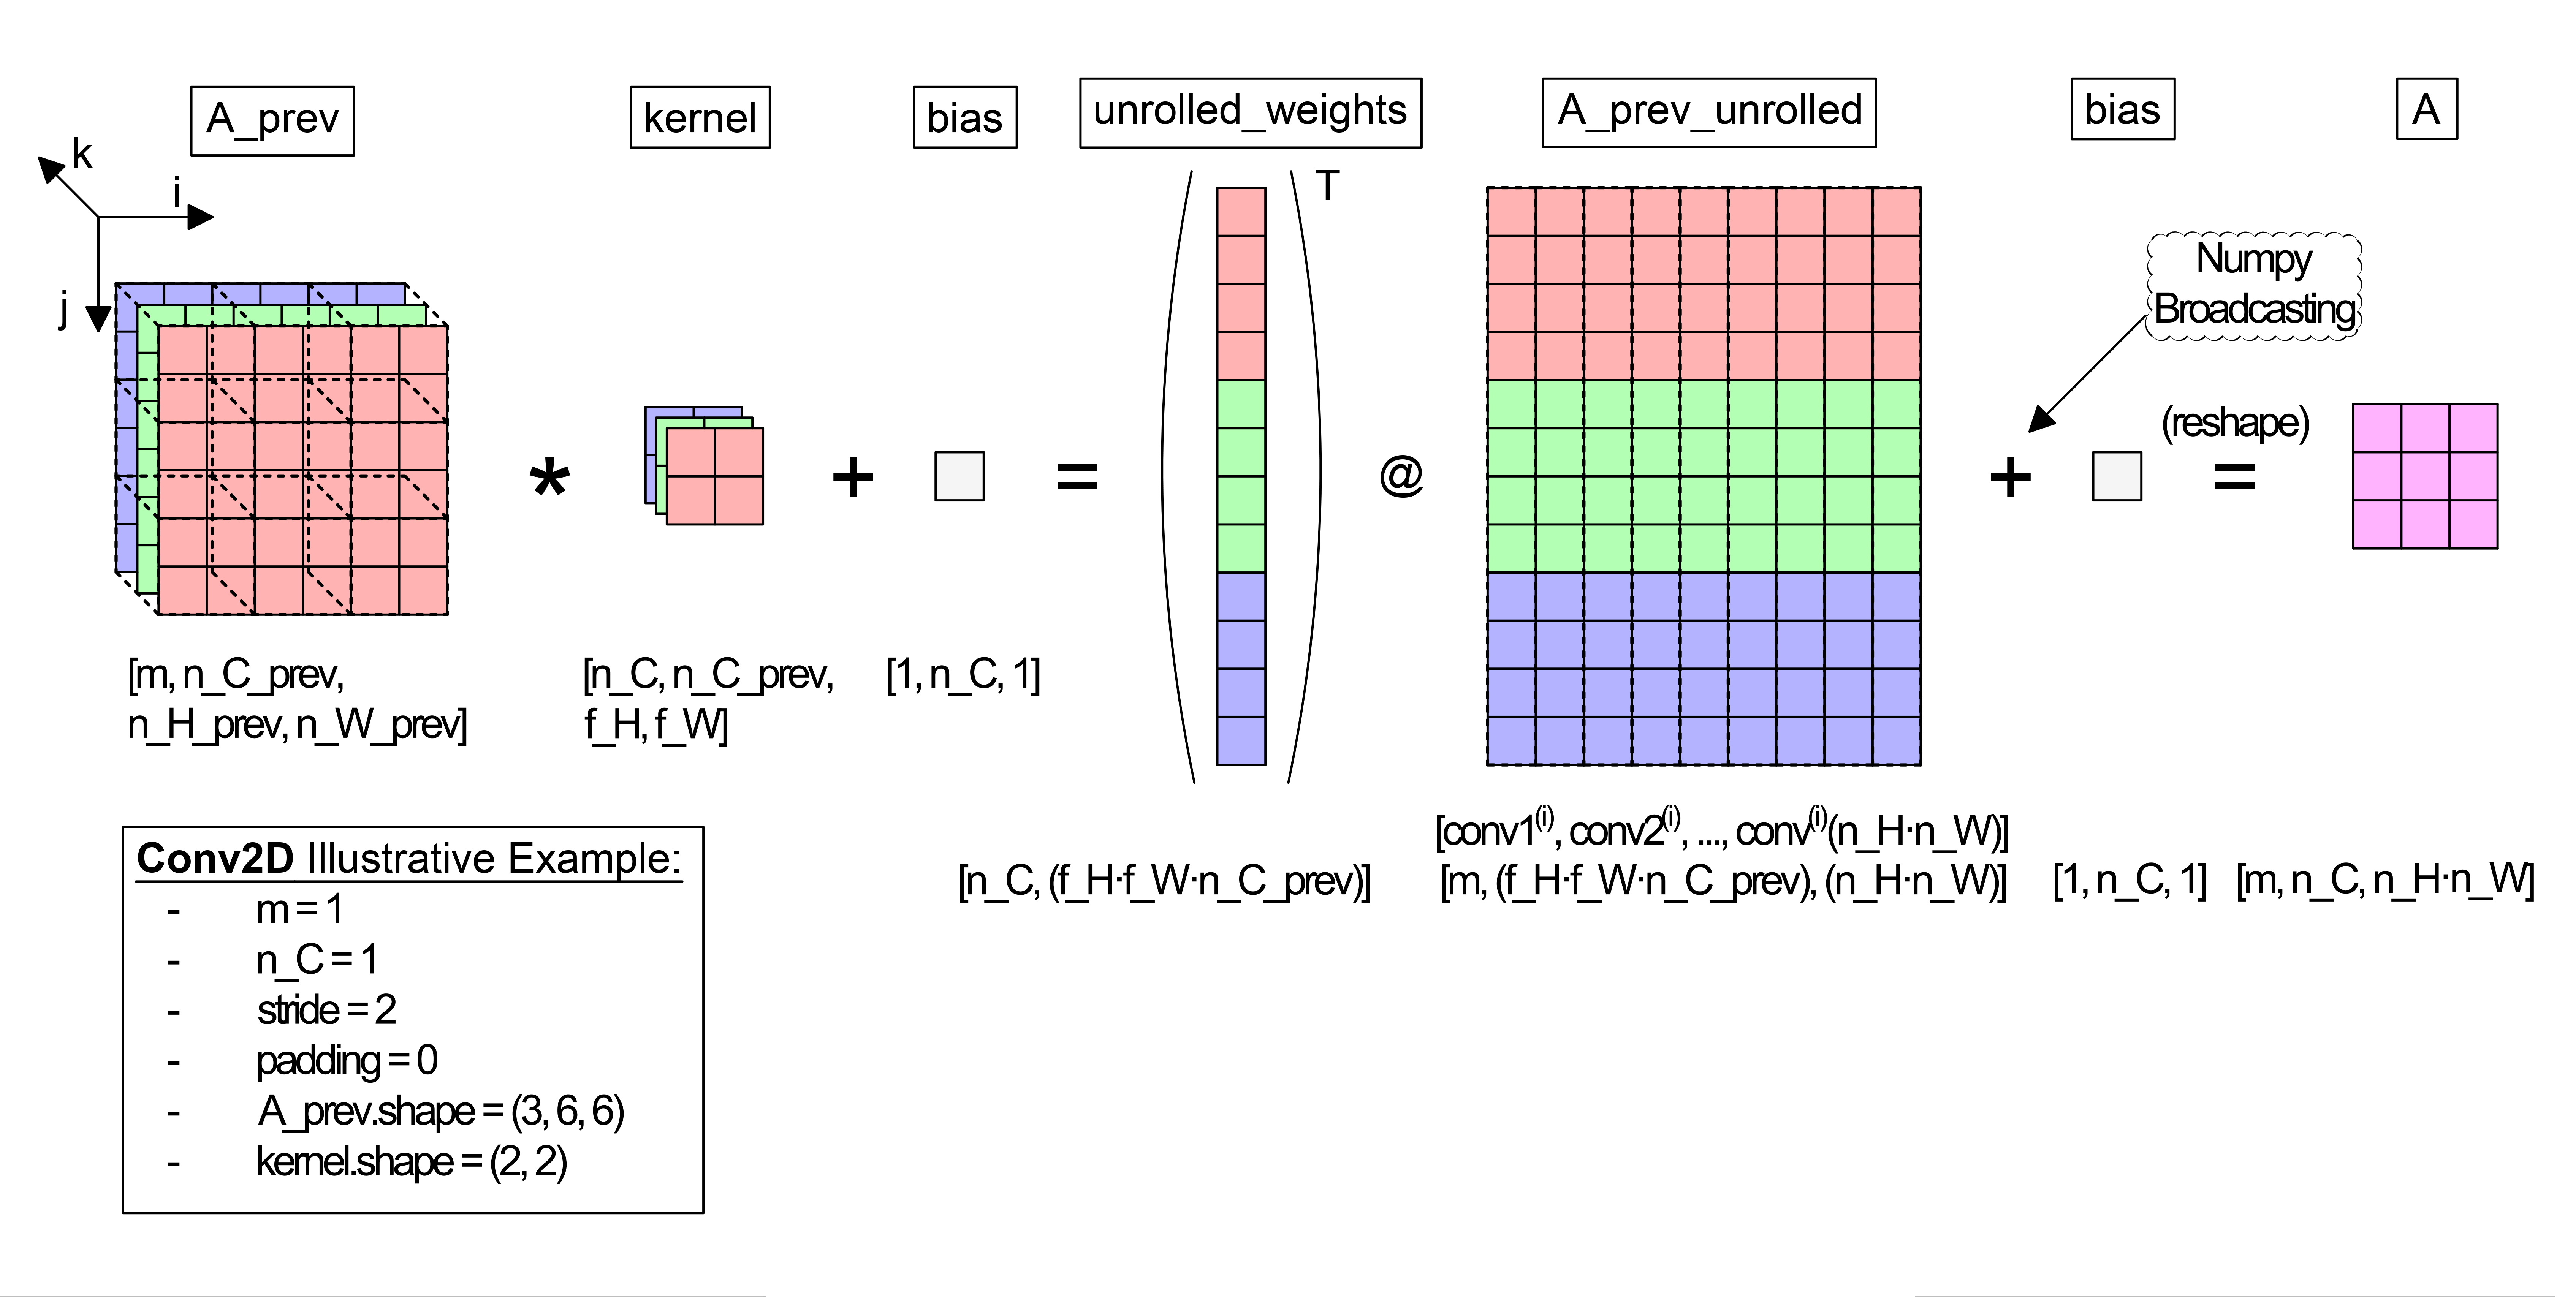

**Useful info:**
- The filters have always the same number of channels with the input image.
- The number of output channels is equal to the number of filters.
- The output image dimensions of a convolutional layer with input image dimensions *(n_C_prev, n_H_prev, n_W_prev)*, stride *s*, padding *p* and number of filters *n_C* with dimensions (n_C_prev, f_H, f_W) is *(n_C, n_H, n_W)*, where:

      n_H = int((n_H_prev + 2p - f_H)/s) + 1 (round down to the closest integer)
      n_W = int((n_W_prev + 2p - f_W)/s) + 1 (round down to the closest integer)
      n_C -> the number of filters (kernels) in the convolutional layer



In [ ]:
def Conv2D (A_prev, kernel, bias, hparameters):
    
    """
    This function works with the following notation:
        
    A) kernel (filter) size: (n_C,f_H,f_W,f_C)
        where:
            n_C: the number of filters (= no. of output channels)
            f_C: filter channels (always equal to the no. of input channels)
            f_H: filter height
            f_W: filter width
    B) Bias size: (n_C,1)
    
    C) Input size: (m,n_C_prev,n_H_prev,n_W_prev)
        where:
            m: number of examples
            n_C_prev: no. of input channels
            f_H_prev: input height
            f_W_prev: input width
    D) hparameters: A dictionary that contains:
            "stride": the stride size of the convolution
            "pad" : the padding size of the convolution
                    if "pad" = 'same': same convolution (output size = input size)
                    if "pad" = 'valid': valid convolution (no padding)
    """

    # Shapes
    n_C, f_C, f_H, f_W = kernel.shape
    m, n_C_prev, n_H_prev, n_W_prev = A_prev.shape
    
    #Assert that hparameters dictionary contains keys 'stride' and 'pad'
    assert ('stride' in hparameters.keys()), 'add "stride" in hparameters dict'
    assert ('pad' in hparameters.keys()), 'add "pad" in hparameters dict'
    
    # Bias size assertion
    condition =  bias.shape == (1, n_C, 1) or bias.shape == (n_C, 1)
    assert condition, 'Wrong bias size, must be: (1, n_C, 1) or (n_C, 1)'

    # Bias reshape
    if bias.shape == (n_C, 1):
      bias = np.expand_dims(bias, axis=0)
    
    # Get stride
    stride = hparameters.get ('stride')
    
    # Get padding size and calculate it in case of 'valid' or 'same'
    pad = hparameters.get ('pad')
    
    if (pad == 'valid'):
        pad = (0, 0)
    elif (pad == 'same'):
        condition = (stride == 1) and (f_H % 2 == 0 or f_W % 2 == 0)
        assert not condition, "Support only symmetrical padding: pick odd dimension filter"
        pad = (RoundUp ((n_H_prev * (stride - 1) + f_H - stride) / 2), RoundUp ((n_W_prev * (stride - 1) + f_W - stride) / 2))
    
    pad_H = pad[0]
    pad_W = pad[1]
    
    # If condition returns False, AssertionError is raised:
    assert f_C == n_C_prev, "No of filter channels must be equal to no of input channels"
    
    # Compute output shape
    n_H = int ((n_H_prev + 2 * pad_H - f_H) / stride) + 1
    n_W = int ((n_W_prev + 2 * pad_W - f_W) / stride) + 1
    
    # Apply padding
    A_prev_pad = np.pad(A_prev, ((0,0), (0,0), (pad_H, pad_H), (pad_W, pad_W)), mode='constant', constant_values=(0,0))
    # Update n_H_prev and n_W_prev values
    _, _, n_H_prev, n_W_prev = A_prev_pad.shape
    
    # Compute patterns along axis 0 and 1 for the unrolled 
    # image matrix indices
    i0 = np.tile (np.repeat(np.arange (f_H), f_W), n_C_prev)
    i1 = np.repeat(stride * np.arange(n_H), n_W)
    
    j0 = np.tile (np.tile (np.arange (f_W), f_H), n_C_prev)
    j1 = np.tile (stride * np.arange(n_W), n_H)
    
    k0 = np.repeat (np.arange (n_C_prev), f_H * f_W)
    k1 = np.zeros ((1, n_H*n_W), dtype = np.int8)
    
    # Compute unrolled image matrix indices
    i = i0.reshape(-1,1) + i1.reshape(1,-1)
    j = j0.reshape(-1,1) + j1.reshape(1,-1)
    k = k0.reshape(-1,1) + k1.reshape(1,-1)
    
    # Save indices in dictionary
    indices = {'i': i, 'j' : j, 'k' : k}
    
    # Compute unrolled image matrix and unrolled weights matrix
    A_prev_unrolled = A_prev_pad [:, k, i, j]
    unrolled_weights = kernel.reshape (n_C, -1)
    
    # Compute unrolled convolution as a dot product of
    # unrolled weights matrix and unrolled image matrix
    A_unrolled = np.matmul(unrolled_weights, A_prev_unrolled) + bias
    A = A_unrolled.reshape(m, n_C, n_H, n_W)
    
    # Save the useful values for backprop at cache (tuple)
    cache = (A_prev, A_prev_unrolled, kernel, bias, hparameters, indices)
    
    return A, cache

# **Pool2D**

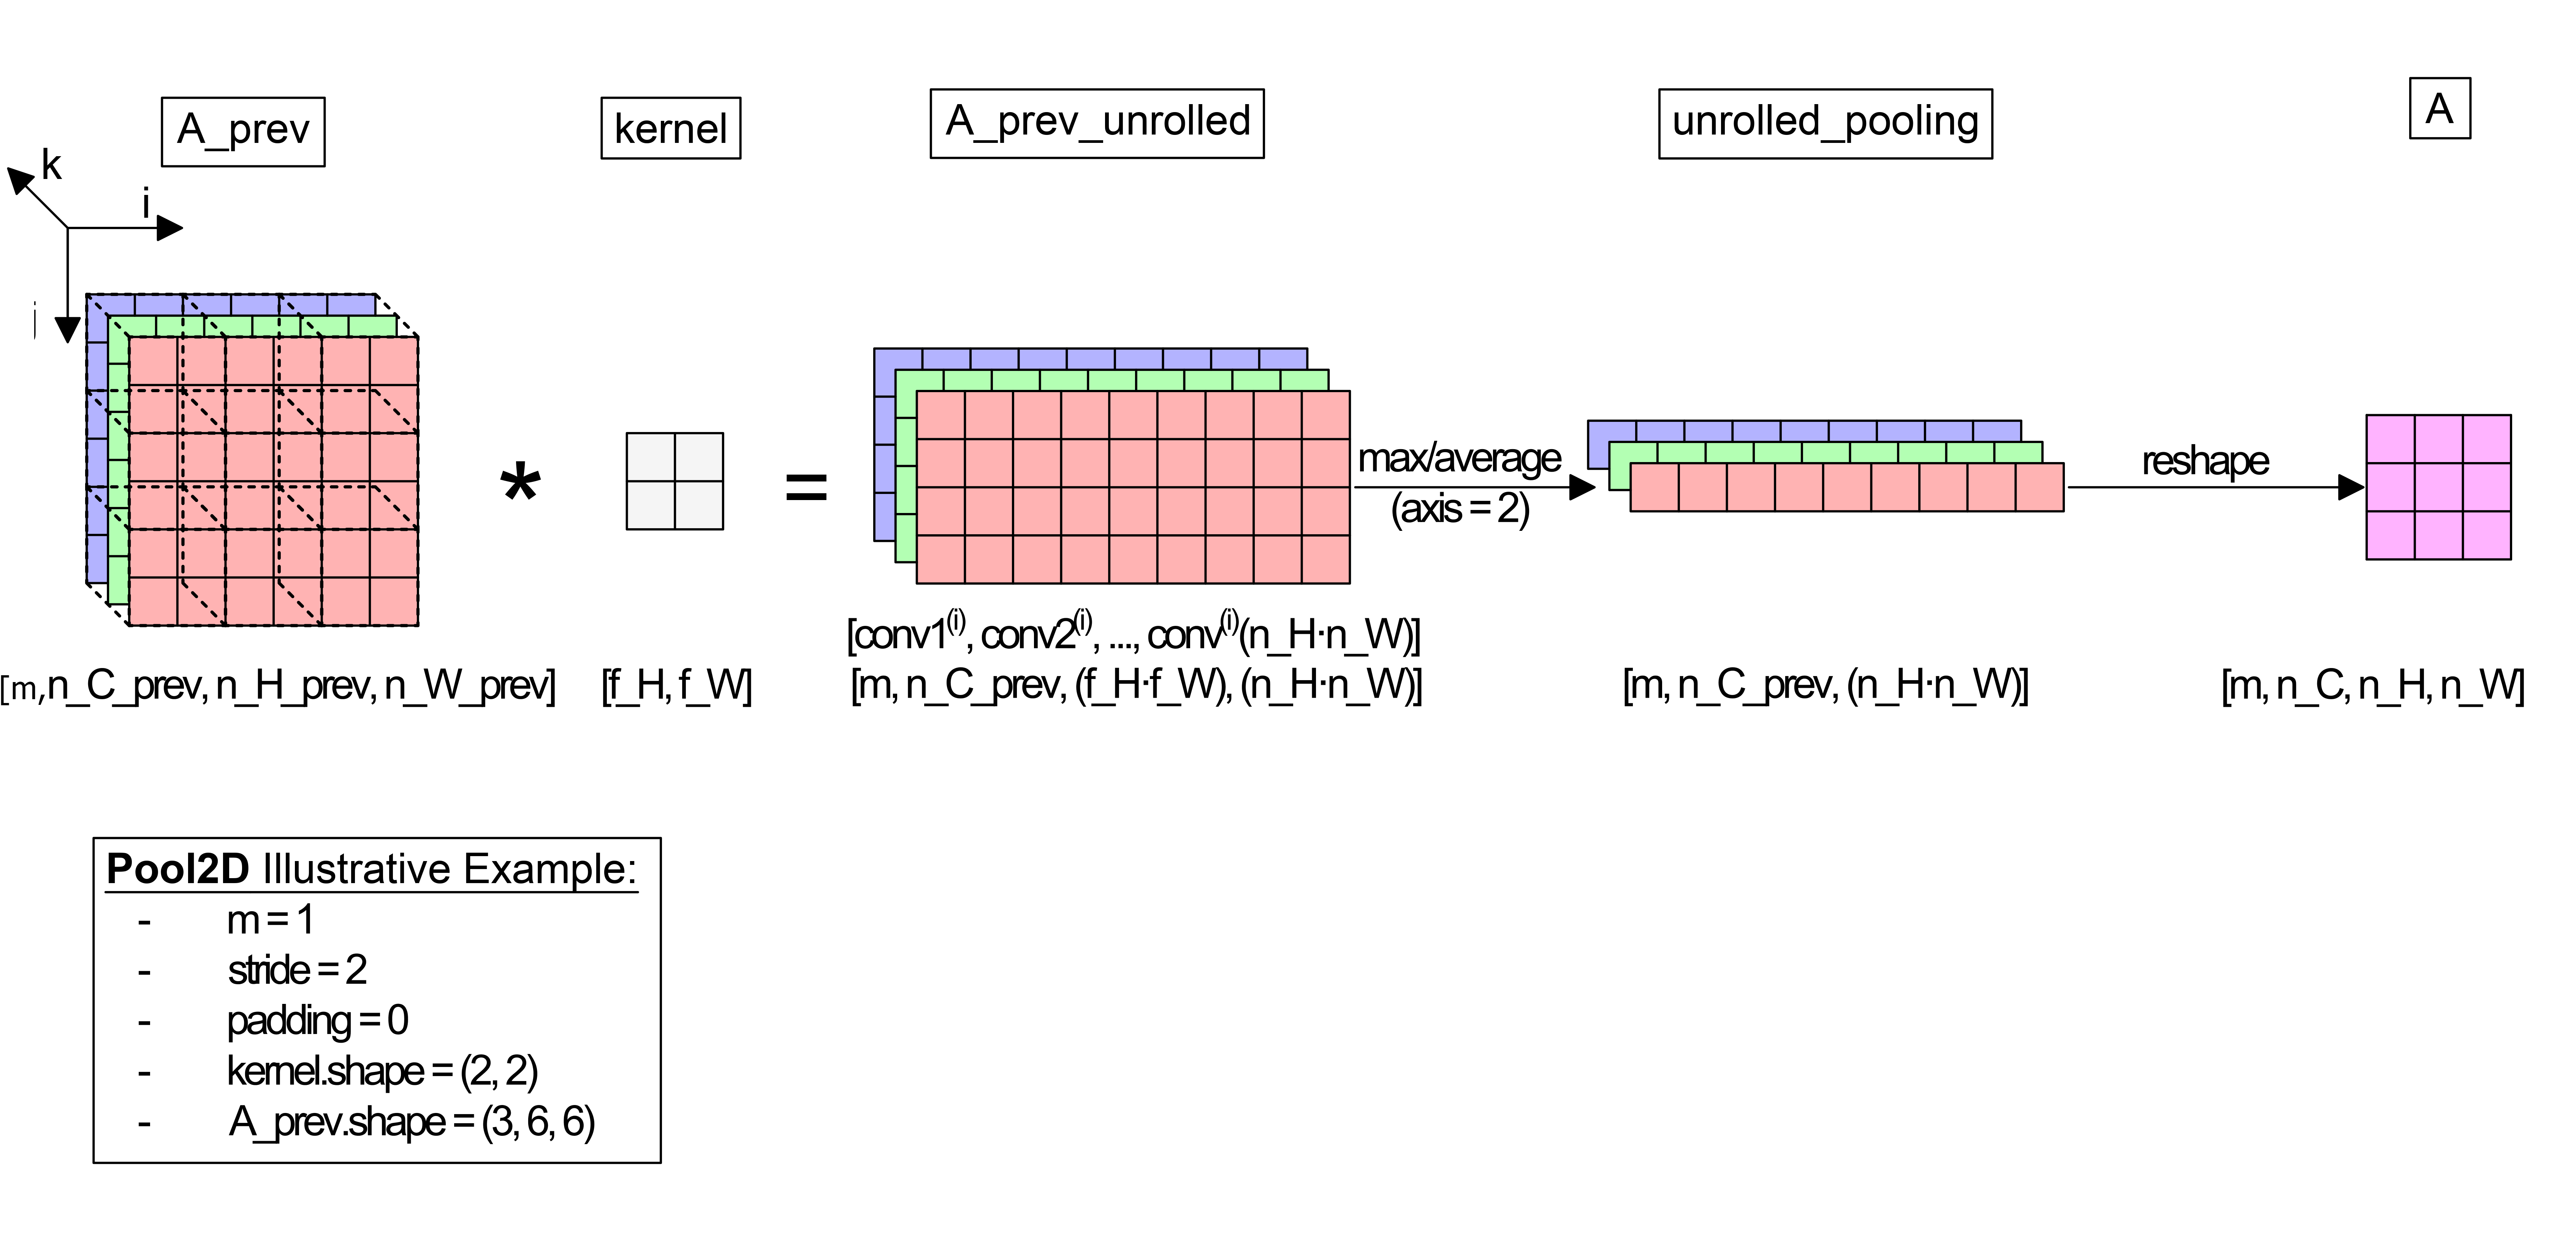

**Useful info:**
- Pooling does not affect the number of channels of the output (it remains equal to the number of input channels).
- Pooling does not have any learnable parameters.
- The height and width of the output image is calculated with the same equations provided in the Conv2D section.

In [ ]:
def Pool2D (A_prev,hparameters):
    
    """
    This function works with the following notation:
        
    A) kernel (filter) size: (f_H,f_W)
        where:
            f_H: filter height
            f_W: filter width
    
    B) Input size: (m,n_C_prev,n_H_prev,n_W_prev)
        where:
            m: number of examples
            n_C_prev: no. of input channels (= no. of output channels)
            f_H_prev: input height
            f_W_prev: input width
    C) ptype = 'max' or 'average' for max/average pooling respectively 
    
    """

    # Image shape
    m, n_C_prev, n_H_prev, n_W_prev = A_prev.shape
    
    #Assert that hparameters dictionary contains keys 'stride', 'kernel' and 'ptype'
    assert('stride' in hparameters.keys()), 'add "stride" in hparameters dict'
    assert('kernel' in hparameters.keys()), 'add "kernel" in hparameters dict'
    assert('ptype' in hparameters.keys()), 'add "ptype" in hparameters dict'
    
    # Get parameters
    stride = hparameters.get('stride')
    kernel = hparameters.get('kernel')
    f_H = kernel[0]
    f_W = kernel[1]
    ptype = hparameters.get('ptype')
    
    # ptype
    condition = (ptype == 'max' or ptype == 'average')
    assert condition, "Wrong ptype value (max or average)"
    
    # Compute output shape
    n_H = int((n_H_prev-f_H) / stride) + 1
    n_W = int((n_W_prev-f_W) / stride) + 1
    n_C = n_C_prev
    
    # Compute patterns along axis 0 and 1 for the unrolled 
    # image matrix indices
    i0 = np.repeat(np.arange(f_H), f_W)
    i1 = np.repeat(stride * np.arange(n_H), n_W)
    
    j0 = np.tile(np.arange(f_W), f_H)
    j1 = np.tile(stride * np.arange(n_W), n_H)
    
    # Compute unrolled image matrix indices
    i = i0.reshape(-1,1) + i1.reshape(1,-1)
    j = j0.reshape(-1,1) + j1.reshape(1,-1)
    
    # Save indices in dictionary
    indices = {'i': i, 'j' : j}
    
    # Compute unrolled image matrix
    A_prev_unrolled = A_prev [:, :, i, j]
    
    # Compute unrolled pooling
    if (ptype == 'max'):
        unrolled_pooling = np.max (A_prev_unrolled, axis=2)
    elif (ptype == 'average'):
        unrolled_pooling = np.average (A_prev_unrolled, axis=2)
    
    A = unrolled_pooling.reshape(m, n_C, n_H, n_W)
    cache = (A_prev, A_prev_unrolled, hparameters, indices)

    return A, cache

In [ ]:
def ReLU(z):
    a = np.where(z>0, z, 0)
    return a

# **Backward Propagation**

# **Conv2D_back:**
**A = W_unrolled @ A_prev_unrolled + b**

Where:
- W_unrolled: unrolled weights
- A_prev_unrolled: the unrolled A_prev matrix - each column i contains the elements of the ith convolution.
- b: bias

Equations for calculating the gradients, implementing the chain rule and working out the matrices shapes:

**1. Bias gradient:** 

*dJ/db = (dJ/dA) ⋅ (dA/db) = np.sum(dA, axis=(0, 2, 3)) (the sum over m, n_H & n_W axes)*

**2. Image gradient:**

*dJ/dA_prev = (dJ/dA) ⋅ (dA/dA_prev) = W_unrolled ⋅ dA ->*
 
*dA_prev_unrolled = unrolled_weights.T @ dZ.reshape(m, n_C, -1)*

*dA_prev = inverse_mapping(dA_prev_unrolled)*

**3. Weights gradient:**

*dJ/dW = (dJ/dA) ⋅ (dA/dW) = dA_prev_unrolled ⋅ dA ->*

*dW = np.sum(dZ.reshape(m, n_C, -1) @ np.transpose(A_prev_unrolled, (0,2,1)), axis=0)*

*dW = dW.reshape(kernel.shape)*

  **Note 1:** The gradients **dJ/di** are indicated as **di**.

  **Note 2:** **dfoo** and **foo** have the same shape.

In [ ]:
def Conv2D_back (dA, cache):

    (A_prev, A_prev_unrolled, kernel, bias, hparameters, indices) = cache
    n_C, f_C, f_H, f_W = kernel.shape
    stride = hparameters.get("stride")
    pad_H = hparameters.get("pad")[0]
    pad_W = hparameters.get("pad")[1]
    i = indices.get("i")
    j = indices.get("j")
    k = indices.get("k")
    (m, n_C, n_H, n_W) = dA.shape
    (m, n_C_prev, n_H_prev, n_W_prev) = A_prev.shape

    
    # Weights Gradient
    dW = np.sum(dA.reshape(m, n_C, -1) @ np.transpose(A_prev_unrolled, (0,2,1)), axis=0)
    dW = dW.reshape(kernel.shape)
    
    # Bias Gradient: The sum over the m, n_H, n_W axes
    db=np.sum(dA, axis=(0,2,3))
    db = db.reshape(1, n_C, 1)
    
    # Image Gradient
    unrolled_weights = kernel.reshape (n_C, -1)
    dA_prev_unrolled = unrolled_weights.T @ dA.reshape(m, n_C, -1)
    # Create empty padded array with the padded dimensions of A_prev
    zero_padded = np.zeros ((m, n_C_prev, n_H_prev + 2 * pad_H , n_W_prev + 2 * pad_W), dtype=dA.dtype)
    # Store gradient in the corresponding locations ("deconvolution" to the A_prev padded dimensions)
    np.add.at(zero_padded, (slice(None), k, i, j), dA_prev_unrolled)
    # Compute input image Gradient by "de-padding" (back to A_prev dimensions) 
    dA_prev = zero_padded[:,:,pad_H:-pad_H, pad_W:-pad_W]    
    
    
    return dA_prev, dW, db

# **Pool2D_back:**

Equations for calculating the image gradient for the pooling layer:

**1. Max Pool:** 

We use a matrix to utileze numpy broadcasting feature:

*broad_matrix = np.zeros((m, n_C, f_H * f_W, n_H * n_W))*

We reshape the matrix dA, in order to have a shape = (m, n_C, f_H * f_W, n_H * n_W):

*dA_prev_unrolled = broad_matrix + np.transpose(dA.reshape(m, n_C,-1,1),(0,1,3,2))*

We need the indices of the max elements of dA_prev_unrolled matrix (calculated in the forward propagation step), to create a mask, which we use to zero out the gradients in all other indices.

*mask = A_prev_unrolled.max(axis=2,keepdims=1) == A_prev_unrolled*

dA_prev_unrolled is a matrix with the same shape as A_unrolled (as we seen in the forward propagation step) in which all the elements of a column i (convolution i) are equal. We want to apply the mask calculated above to this matrix to zero out the gradients in all cells, except the ones that had the element with the max value.

*dA_prev_masked = mask * dA_prev_unrolled*

Finally, we use the inverse-mapping to calculate the dA gradient.

**2. Average Pool:**
Same computation steps as in Max Pool. Here we don't need to mask the dA_prev_unrolled matrix. Instead we first divide each element of dA matrix with (f_H ⋅ f_W = the total number of elements of each convolution)

*dA = dA / (f_H * f_W)*

Then we use the broadcasting matrix to reshape dA to (m, n_C, f_H * f_W, n_H * n_W): 

*dA_prev_unrolled = broad_matrix + np.transpose(dA.reshape(m, n_C,-1,1),(0,1,3,2))*

In the final step we use the inverse-mapping to calculate the dA gradient.

  **Note 1:** The gradients **dJ/di** are indicated as **di**.

  **Note 2:** **dfoo** and **foo** have the same shape.

In [ ]:
def Pool2D_back (dA, cache):
    
    (A_prev, A_prev_unrolled, hparameters, indices) = cache
    
    # Get parameters
    stride = hparameters.get('stride')
    f_H = hparameters.get('kernel')[0]
    f_W = hparameters.get('kernel')[1]
    ptype = hparameters.get('ptype')
    
    i = indices.get("i")
    j = indices.get("j")
    (m, n_C, n_H, n_W) = dA.shape
    (m, n_C_prev, n_H_prev, n_W_prev) = A_prev.shape
    
    # Pool Gradient
    # Create empty padded array with the padded dimensions of A_prev
    dA_prev = np.zeros ((m, n_C_prev, n_H_prev , n_W_prev), dtype=dA.dtype)
    broad_matrix = np.zeros((m, n_C, f_H * f_W, n_H * n_W))
    
    if (ptype == 'max'):     
        dA_prev_unrolled = broad_matrix + np.transpose(dA.reshape(m, n_C,-1,1),(0,1,3,2))
        # Create mask from max indices of dA_prev_unrolled
        mask = A_prev_unrolled.max(axis=2,keepdims=1) == A_prev_unrolled
        dA_prev_masked = mask * dA_prev_unrolled
        # Store gradient in the corresponding locations
        np.add.at(dA_prev, (slice(None), slice(None), i, j), dA_prev_masked)   
    elif (ptype == 'average'):
        dA = dA / (f_H * f_W)
        dA_prev_unrolled = broad_matrix + np.transpose(dA.reshape(m, n_C,-1,1),(0,1,3,2))
        # Store gradient in the corresponding locations
        np.add.at(dA_prev, (slice(None), slice(None), i, j), dA_prev_unrolled)                
    
    return dA_prev

In [ ]:
def ReLU_back(A):
    dA = np.where(A>0, 1, 0)
    return dA

# **Forward Propagation Check**
Lets load PyTorch and run some experiments!!!

In [ ]:
import torch
import torch.nn as nn
from time import time

In [ ]:
# Random example
torch.manual_seed(0)
example_input=torch.randn(3,10)
print('example_input:', example_input)

example_input: tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.8487,  0.6920, -0.3160, -2.1152,
          0.3223, -1.2633],
        [ 0.3500,  0.3081,  0.1198,  1.2377, -0.1435, -0.1116, -0.6136,  0.0316,
         -0.4927,  0.2484],
        [ 0.4397,  0.1124, -0.8411, -2.3160, -0.1023,  0.7924, -0.2897,  0.0525,
          0.5229,  2.3022]])


In [ ]:
# pyTorch Convolutional Layer
start = time()
layer1 = nn.Conv2d(1, 1, 2, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
Z1 = layer1(torch.reshape(example_input,(1,1,3,10)))
end = time()
kernel = layer1.weight.detach()
bias = layer1.bias.detach()
print('Conv. output:', Z1)
print('bias:', bias)
print('kernel:', kernel)
print('time duration:', end-start, 's')

Conv. output: tensor([[[[-0.4564, -0.1877,  0.0646,  0.1599,  0.8242,  0.4813, -0.2645,
           -0.2511,  0.1559],
          [ 0.4210,  0.4424,  0.9487,  1.1836,  0.2502, -0.0658,  0.1988,
            0.1642,  0.0797]]]], grad_fn=<ThnnConv2DBackward>)
bias: tensor([0.3198])
kernel: tensor([[[[ 0.3155,  0.2932],
          [-0.2217, -0.0180]]]])
time duration: 0.05417037010192871 s


In [ ]:
# pyTorch ReLU activation
start = time()
activation = nn.ReLU()
A1 = activation(Z1)
end = time()
print('ReLU activation:', A1)
print('time duration:', end-start, 's')

ReLU activation: tensor([[[[0.0000, 0.0000, 0.0646, 0.1599, 0.8242, 0.4813, 0.0000, 0.0000,
           0.1559],
          [0.4210, 0.4424, 0.9487, 1.1836, 0.2502, 0.0000, 0.1988, 0.1642,
           0.0797]]]], grad_fn=<ReluBackward0>)
time duration: 0.0006361007690429688 s


In [ ]:
# pyTorch Pooling Layer
start = time()
layer2 = nn.MaxPool2d(2, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
P1 = layer2(A1)
end = time()
print('Pool output:', P1)
print('time duration:', end-start, 's')

Pool output: tensor([[[[0.4424, 1.1836, 0.8242, 0.1988]]]],
       grad_fn=<MaxPool2DWithIndicesBackward>)
time duration: 0.0077893733978271484 s


In [ ]:
# Conv2D Layer
start = time()
hparameters = {"pad" : (0,0), "stride": 1}
iZ1, cache_conv = Conv2D(example_input.reshape(1,1,3,10), kernel, bias.reshape(1,1,1), hparameters)
end = time()
print('Conv. output:', iZ1)
print('time duration:', end-start, 's')

Conv. output: tensor([[[[-0.4564, -0.1877,  0.0646,  0.1599,  0.8242,  0.4813, -0.2645,
           -0.2511,  0.1559],
          [ 0.4210,  0.4424,  0.9487,  1.1836,  0.2502, -0.0658,  0.1988,
            0.1642,  0.0797]]]])
time duration: 0.006838798522949219 s


In [ ]:
# ReLU activation
start = time()
iA1 = ReLU(iZ1)
end = time()
print('ReLU activation:', iA1)
print('time duration:', end-start, 's')

ReLU activation: [[[[0.         0.         0.06463102 0.15985437 0.8242205  0.4812641
    0.         0.         0.15585628]
   [0.42099243 0.44236678 0.94870734 1.1835845  0.2501896  0.
    0.19876146 0.16423695 0.07970394]]]]
time duration: 0.00037932395935058594 s


In [ ]:
# Pool2D Layer
start = time()
hparameters = {"stride" : 1, "kernel": (2,2), "ptype":'max'}
iP1, cache_pool = Pool2D(iA1, hparameters)
end = time()
print('Pool output:', iP1)
print('time duration:', end-start, 's')

Pool output: [[[[0.44236678 0.94870734 1.1835845  1.1835845  0.8242205  0.4812641
    0.19876146 0.16423695]]]]
time duration: 0.000324249267578125 s


# **Backward Propagation Check**

Unfortunately, as far as I know, there is no way to manually calculate the gradients in the back-prop step with PyTorch.

The test code blocks of Coursera are used to check the backward propagation functions.

In [ ]:
np.random.seed(1)

A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
hparameters = {"pad" : (2,2), "stride": 2}

A_prev = np.transpose(A_prev, (0,3,1,2))
W = np.transpose(W, (3,2,0,1))
b = np.random.randn(8,1)

Z, cache_conv = Conv2D (A_prev, W, b, hparameters)

# Test conv_backward
dA_prev, dW, db = Conv2D_back (Z, cache_conv)

dA_prev = np.transpose(dA_prev, (0, 2, 3, 1))
dW = np.transpose(dW, (0, 2, 3, 1))

print("dA_mean =", np.mean(dA_prev))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139088
db_mean = 7.8392325646169265


# **Coursera Output for conv_backward**

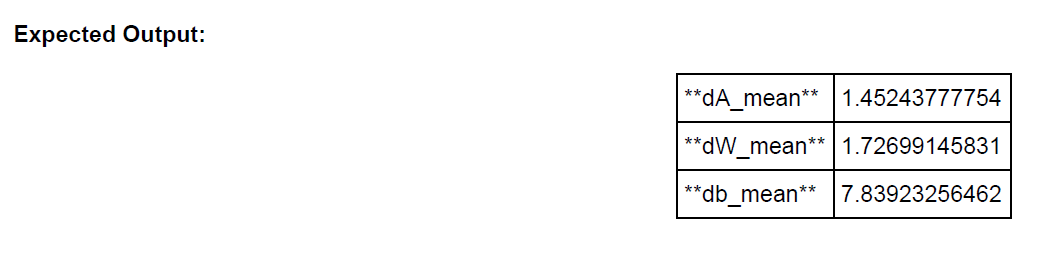

In [ ]:
# Pool2D_back check
# Test block code of Coursera is used
np.random.seed(1)
A_prev=np.random.randn(5,5,3,2)
A_prev = np.transpose(A_prev, (0,3,1,2))

hparameters = {"stride" : 1, "kernel": (2,2), "ptype":'max'}
A,cache=Pool2D(A_prev,hparameters)
dA=np.random.randn(5,4,2,2)
dA=np.transpose(dA, (0,3,1,2))
dA_prev=Pool2D_back(dA,cache)
dA_prev = np.transpose(dA_prev, (0,2,3,1))
print("mode = max")
print('mean of dA = ',np.mean(dA))
print('dA_prev[1,1] = ',dA_prev[1,1])

hparameters = {"stride" : 1, "kernel": (2,2), "ptype":'average'}
A,cache=Pool2D(A_prev,hparameters)
dA_prev=Pool2D_back(dA,cache)
dA_prev = np.transpose(dA_prev, (0,2,3,1))
print("mode = average")
print('mean of dA = ',np.mean(dA))
print('dA_prev[1,1] = ',dA_prev[1,1])

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]
mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


## **Coursera Output for pool_backward**

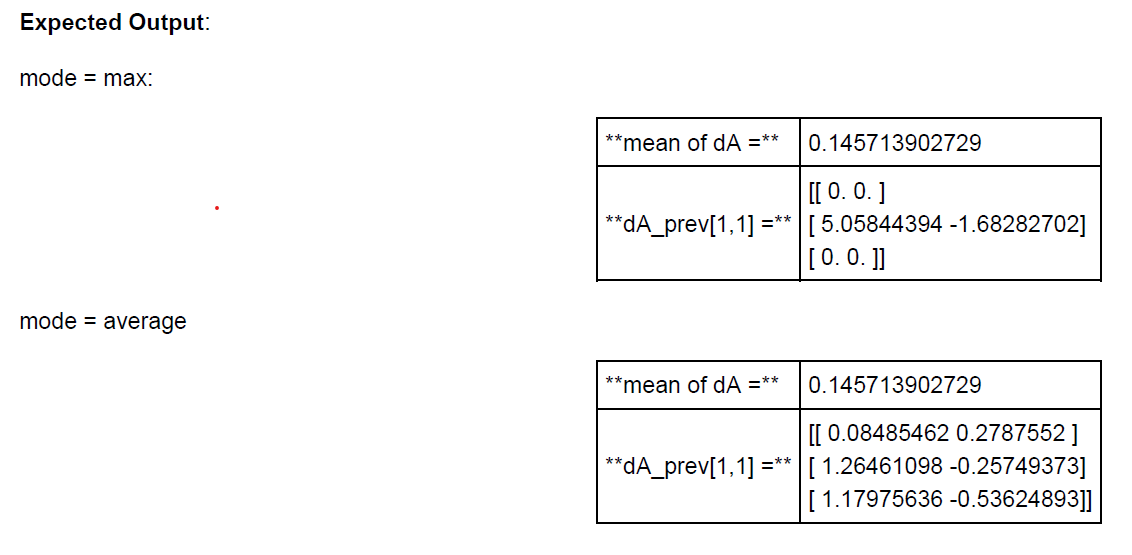